# Exploring San Francisco International Airport Traffic Passenger Statistics

For detailed information about the dataset, please visit [their official website](https://data.sfgov.org/Transportation/Air-Traffic-Passenger-Statistics/rkru-6vcg).

### Downloading the data file

First we send a HTTP GET request and fetch the data

In [1]:
import requests

download_file = requests.get('https://data.sfgov.org/api/views/rkru-6vcg/rows.csv?accessType=DOWNLOAD')
if download_file.status_code != 200:
    print('Error while fetching the data')
else:
    print('Data successfully received')

Data successfully received


Let's look at the location where this data will be saved.

In [2]:
import os
import sys

filename = os.path.join(os.path.dirname(sys.argv[0]), download_file.headers['content-disposition'].split(';')[-1].strip().split('=')[-1])
print('Data will be saved in: ' + filename)

Data will be saved in: c:\users\sudip.a.banerjee\pycharmprojects\learning\venv\lib\site-packages\Air_Traffic_Passenger_Statistics.csv


Now we save the data

In [3]:
op_file = open(filename, 'wb')
op_file.write(download_file.content)
op_file.close()

Let's see the top 5 rows of the file

In [4]:
file = open(filename, 'r')
for _ in range(5):
    print(file.readline())
file.close()

Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count

200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271

200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131

200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415

200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156



### Reading the file in Pandas

Let's import the required libraries

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

Now let's read the file using Pandas and check if the loaded data looks fine

In [6]:
df = pd.read_csv(filename)

In [7]:
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090


### Data Wrangling in Pandas

Let's check the general info about the Dataframe

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22120 entries, 0 to 22119
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Activity Period              22120 non-null  int64 
 1   Operating Airline            22120 non-null  object
 2   Operating Airline IATA Code  22057 non-null  object
 3   Published Airline            22120 non-null  object
 4   Published Airline IATA Code  22057 non-null  object
 5   GEO Summary                  22120 non-null  object
 6   GEO Region                   22120 non-null  object
 7   Activity Type Code           22120 non-null  object
 8   Price Category Code          22120 non-null  object
 9   Terminal                     22120 non-null  object
 10  Boarding Area                22120 non-null  object
 11  Passenger Count              22120 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 2.0+ MB


The field 'Activity Period' belongs to String datatype (which is shown as object). Let's convert it to a DateTime Object.

In [9]:
df['Activity Period'] = pd.to_datetime(df['Activity Period'], format='%Y%m')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22120 entries, 0 to 22119
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Activity Period              22120 non-null  datetime64[ns]
 1   Operating Airline            22120 non-null  object        
 2   Operating Airline IATA Code  22057 non-null  object        
 3   Published Airline            22120 non-null  object        
 4   Published Airline IATA Code  22057 non-null  object        
 5   GEO Summary                  22120 non-null  object        
 6   GEO Region                   22120 non-null  object        
 7   Activity Type Code           22120 non-null  object        
 8   Price Category Code          22120 non-null  object        
 9   Terminal                     22120 non-null  object        
 10  Boarding Area                22120 non-null  object        
 11  Passenger Count              22120 non-nu

While exploring the data, it was observed that United Airlines has two registered names, namely 'United Airlines - Pre 07/01/2013' and 'United Airlines'. This distinction is irrelevant for our analysis and thus we'll replace all such instances to 'United Airlines'.

In [11]:
df['Operating Airline'].replace({'United Airlines - Pre 07/01/2013': 'United Airlines'}, inplace=True)
df['Published Airline'].replace({'United Airlines - Pre 07/01/2013': 'United Airlines'}, inplace=True)

### Data Analysis in Pandas

Let's analyse the available data.

##### What is the minimum (start) and the maximum (end) of the Activity Period ?

We learn how to aggregate data on a Series object.

In [12]:
print('Data from', df['Activity Period'].min(), 'till', df['Activity Period'].max(), 'is received.')

Data from 2005-07-01 00:00:00 till 2020-03-01 00:00:00 is received.


##### How did the Top 3 Airlines perform over time?

* First we find the overall Top 3 Airlines and store it in a list.
* Then we filter the data for these Airlines, sort and aggregate on Activity Period and Operating Airline.
* In order to make it readable, we pivot the data.
* At last, we plot a line graph with a log scale on the y-axis.

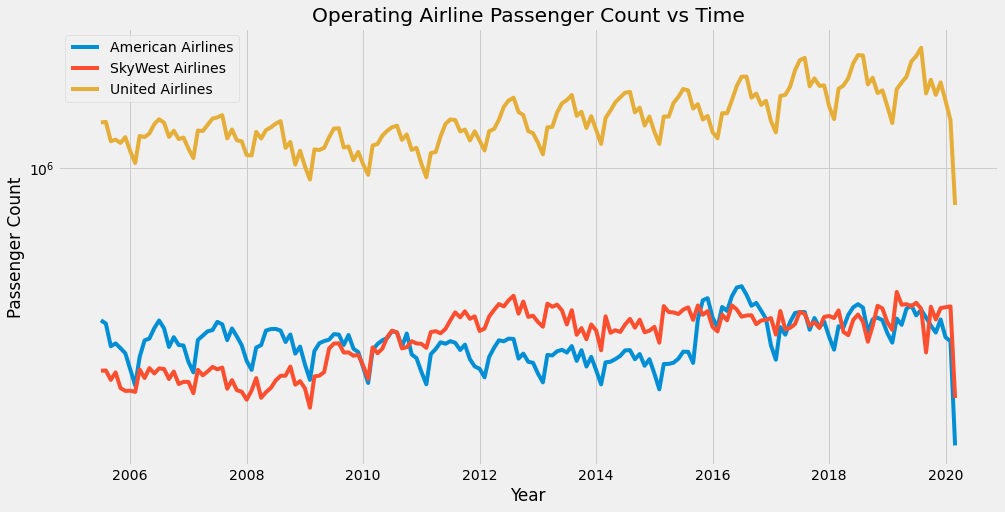

In [22]:
%matplotlib inline
popular_airlines = df[['Operating Airline', 'Passenger Count']]\
                        .sort_values(by='Operating Airline')\
                        .groupby('Operating Airline')\
                        .sum()\
                        .sort_values(by='Passenger Count', ascending=False)\
                        .head(3)\
                        .index\
                        .to_list()
op = df.loc[df['Operating Airline'].isin(popular_airlines), ['Activity Period', 'Operating Airline', 'Passenger Count']]\
        .sort_values(by=['Activity Period', 'Operating Airline'])\
        .groupby(['Activity Period', 'Operating Airline'])\
        .sum()\
        .reset_index()\
        .pivot(index='Activity Period', columns='Operating Airline', values='Passenger Count')\
        .fillna(0)

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 7.5]
lines = plt.plot(op.index, op)
plt.yscale('log')
plt.legend(lines, op.columns.to_list(), loc='upper left')
plt.title('Operating Airline Passenger Count vs Time')
plt.xlabel('Year')
plt.ylabel('Passenger Count')
plt.show()

##### Geography wise Market Share Analysis (Showing the Airlines which have atleast 5% Market Share)

* First we sort and aggregate on Geo Region and Operating Airline.
* In order to make it readable, we pivot the data.
* Now, each row of the output dataframe signifies a geographic region and thus we iterate for each row of the dataframe.
* For each geography, we filter the airlines which have >5% of total market share for that geography.
* Then we plot a pie charts (subplots for each Goegraphy) with shares of each airline for that geography.

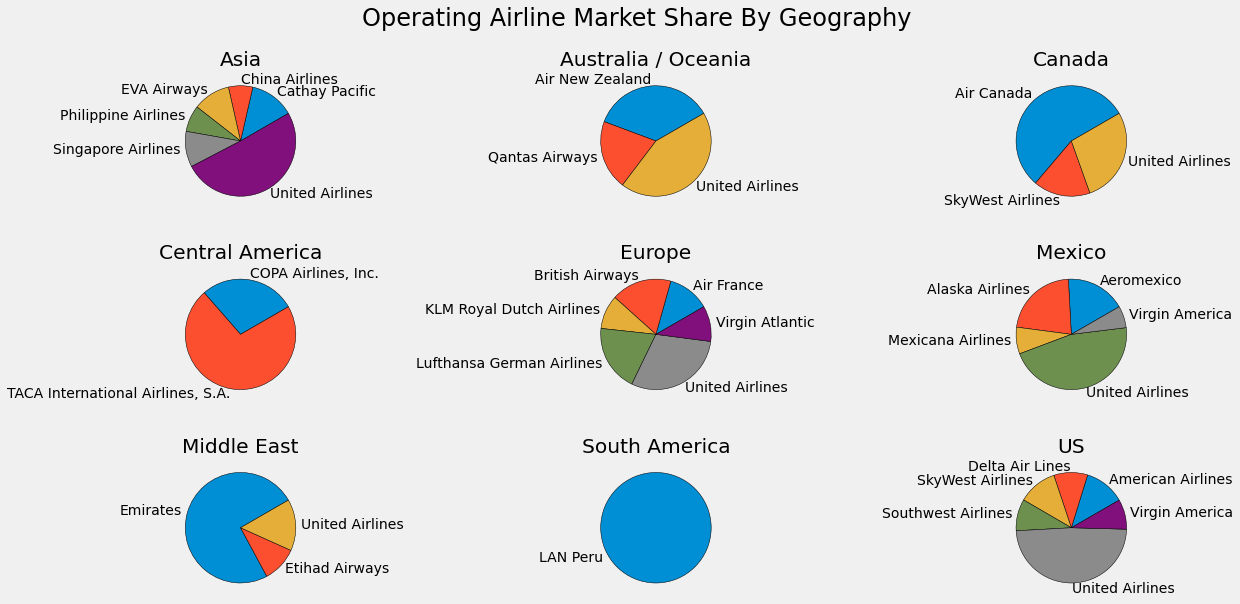

In [18]:
%matplotlib inline
op = df[['GEO Region', 'Operating Airline', 'Passenger Count']]\
        .sort_values(by=['GEO Region', 'Operating Airline'])\
        .groupby(['GEO Region', 'Operating Airline'])\
        .sum()\
        .reset_index()\
        .pivot(index='GEO Region', columns='Operating Airline', values='Passenger Count')\
        .fillna(0)

plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(3, 3, figsize=(18, 9))
for row_num, (idx, row) in enumerate(op.iterrows()):
    ax = axes[row_num // 3, row_num % 3]
    row = row[row.gt(row.sum() * .05)]
    ax.pie(row, labels=row.index, startangle=30, wedgeprops={'edgecolor': 'black'})
    ax.set_title(idx)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Operating Airline Market Share By Geography', fontsize=24)
plt.show()

##### How did the International Air Traffic (Geography wise) evolve over time?

* First we filter the data for International Traffic.
* Then we sort and aggregate on Activity Period and Geo Region.
* The next step is to find the Top 3 Geographies for each Activity Period (month). This is done by using the 'Dense Rank' to rank Geographies for each Activity Period (month).
* Then we filter on the records having Rank <= 3 and save the unique Geographies in a list.
* Then we filter for these regions, pivot the data and plot a line graph.

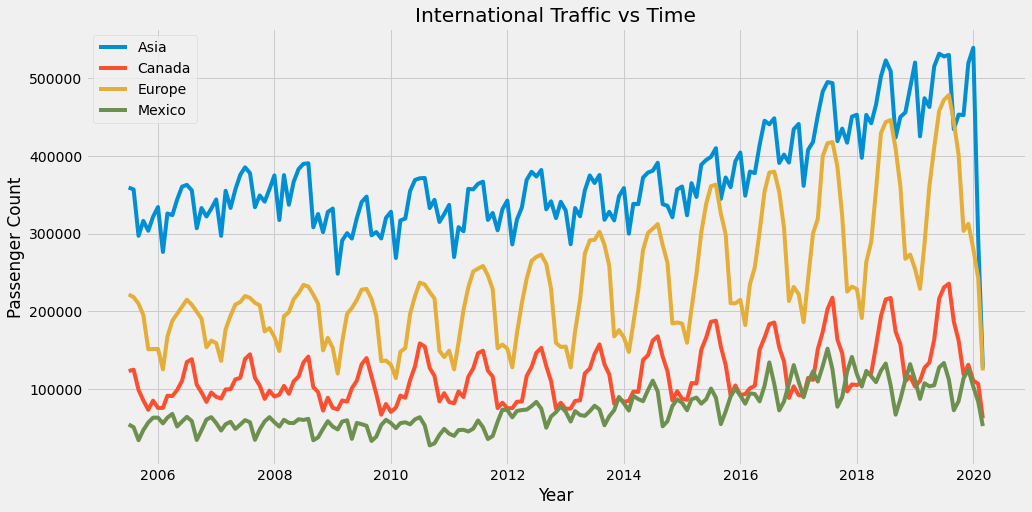

In [23]:
%matplotlib inline
op = df.loc[df['GEO Summary'] == 'International', ['Activity Period', 'GEO Region', 'Passenger Count']]\
        .sort_values(by=['Activity Period', 'GEO Region'])\
        .groupby(['Activity Period', 'GEO Region'])\
        .sum()\
        .reset_index()
op['Rank'] = op.groupby('Activity Period')['Passenger Count'].rank(method='dense', ascending=False)
top_regions = op.loc[op['Rank'] <= 3, 'GEO Region'].unique()
op = op.loc[op['GEO Region'].isin(top_regions), 'Activity Period':'Passenger Count']\
        .reset_index(drop=True)\
        .pivot(index='Activity Period', columns='GEO Region', values='Passenger Count')\
        .fillna(0)

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 7.5]
lines = plt.plot(op.index, op)
plt.legend(lines, op.columns.to_list(), loc='upper left')
plt.title('International Traffic vs Time')
plt.xlabel('Year')
plt.ylabel('Passenger Count')
plt.show()

##### Analyse Airlines' Flight Operations Surplus / Deficit

* First we create a dataframe called 'operated_df' which is obtained by aggregating Passenger Count by Operating Airline.
* Next we create another dataframe called 'published_df' which is obtained by aggregating Passenger Count by Published Airline.
* Then we merge these two dataframes together (Full Outer Join).
* Then we calculate the Difference, which is Operated Passenger Count - Published Passenger Count
* At last we filter the airlines having non-zero Difference and plot it in a horizontal bar chart.

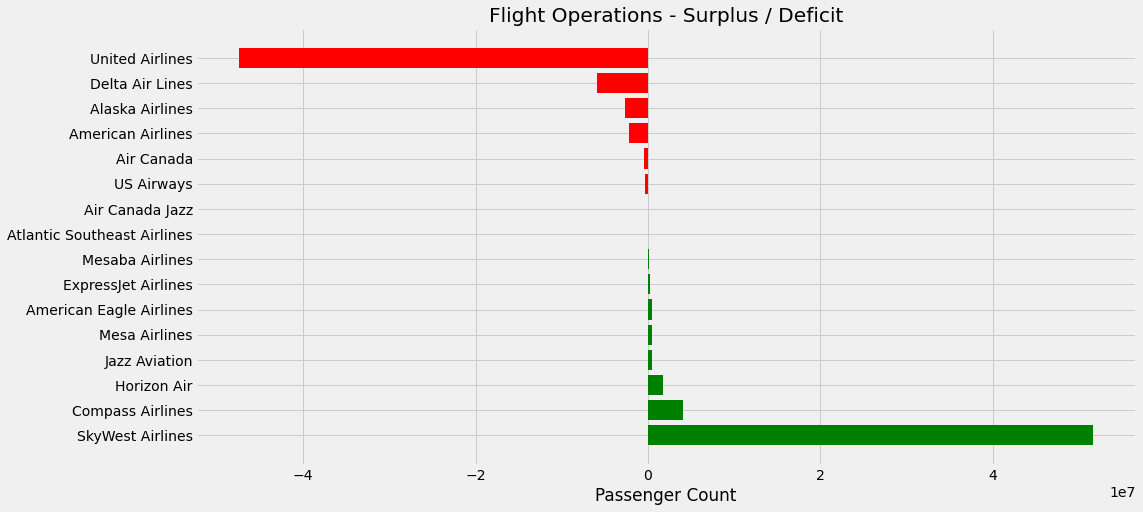

In [59]:
%matplotlib inline
operated_df = df[['Operating Airline', 'Passenger Count']]\
                    .sort_values(by='Operating Airline')\
                    .groupby('Operating Airline')\
                    .sum()\
                    .reset_index()\
                    .rename(columns={'Operating Airline': 'Airline', 'Passenger Count': 'Operated Passenger Count'})
published_df = df[['Published Airline', 'Passenger Count']]\
                    .sort_values(by='Published Airline')\
                    .groupby('Published Airline')\
                    .sum()\
                    .reset_index()\
                    .rename(columns={'Published Airline': 'Airline', 'Passenger Count': 'Published Passenger Count'})

op = operated_df.merge(published_df, how='outer', on='Airline').set_index('Airline').fillna(0)
op['Difference'] = op['Operated Passenger Count'].subtract(op['Published Passenger Count'])
op = op.loc[op['Difference'] != 0].sort_values(by='Difference', ascending=False)

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.barh(op.index, op['Difference'], color=[('red' if bool(tmp['Difference'] < 0) else 'green') for _, tmp in op.iterrows()])
plt.title('Flight Operations - Surplus / Deficit')
plt.xlabel('Passenger Count')
plt.show()

In [ ]:
op = df.loc[df['GEO Summary'] == 'International', ['Activity Period', 'Operating Airline', 'Passenger Count']]
op['Year'] = op['Activity Period'].dt.year
op = op[['Year', 'Operating Airline', 'Passenger Count']].sort_values(by=['Year', 'Operating Airline']).groupby(['Year', 'Operating Airline']).sum().reset_index()

op['Yearly Market Share (%)'] = 0
op['Yearly Growth (%)'] = 0

start_year = int(op['Year'].min())
end_year = int(op['Year'].max())
for ind_year in range(start_year, end_year + 1):
    year_filt = (op['Year'] == ind_year)
    tmp = op.loc[year_filt, 'Passenger Count'].sum()
    op.loc[year_filt, 'Yearly Market Share (%)'] = op.loc[year_filt, 'Passenger Count'].apply(lambda x: (x/tmp)*100)
    if ind_year != start_year:
        airlines = op.loc[year_filt, 'Operating Airline'].to_list()
        for ind_airline in airlines:
            last_year_filt = (op['Year'] == (ind_year - 1))
            airline_filt = (op['Operating Airline'] == ind_airline)
            tmp = op.loc[last_year_filt & airline_filt, 'Passenger Count'].to_list()
            if tmp:
                op.loc[year_filt & airline_filt, 'Yearly Growth (%)'] = op.loc[year_filt & airline_filt, 'Passenger Count'].apply(lambda x: ((x-tmp[0])/tmp[0])*100)

op = op.pivot(index='Operating Airline', columns='Year', values=['Passenger Count', 'Yearly Market Share (%)', 'Yearly Growth (%)']).fillna(0)
op.loc[:, ('Passenger Count', slice(None))]

In [ ]:
chosen_few_airlines = ['Air India Limited', 'British Airways', 'Cathay Pacific', 'China Airlines', 'Emirates', 'Japan Airlines', 'KLM Royal Dutch Airlines',\
                           'Korean Air Lines', 'Lufthansa German Airlines', 'Qantas Airways', 'Singapore Airlines', 'United Airlines']

In [ ]:
op.loc[chosen_few_airlines, ('Yearly Market Share (%)', slice(None))]

In [ ]:
op.loc[chosen_few_airlines, ('Yearly Growth (%)', slice(None))].tail(50)

In [ ]:
x = []
y = []
c = []
for ind_year in range(start_year + 1, end_year + 1):
    x.append(op.loc[:, ('Yearly Market Share (%)', ind_year)].to_list())
    y.append(op.loc[:, ('Yearly Growth (%)', ind_year)].to_list())
    c.append(op.loc[:, ('Passenger Count', ind_year)].to_list())

plt.scatter(x, y, c=c, edgecolor='black', linewidth=1, alpha=0.75, cmap='Reds')
cbar = plt.colorbar()
plt.show()

In [ ]:
plt.scatter(x, y, c=c, edgecolor='black', linewidth=1, alpha=0.75, cmap='Reds')
cbar = plt.colorbar()
axes = plt.gca()
axes.set_ylim([-120,420])
plt.show()